In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from function_utils import display_circles
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_index
from kmodes.kprototypes import KPrototypes
import gc

In [2]:
sns.set_palette("Pastel2")
sns.set_style("ticks")

In [3]:
df = pd.read_csv("datasets/data_segmentation_rfm.csv")
df.set_index("customer_unique_id", inplace=True)
df.head(3)

,Recency,Frequency,MonetaryValue,r_quartile,f_bins,m_quartile,RFM_Score
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,161,1,141.90,1,2,2,122
0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,27.19,1,2,4,124
0000f46a3911fa3c0805444483337064,586,1,86.22,4,2,3,423


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96095 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Recency        96095 non-null  int64  
 1   Frequency      96095 non-null  int64  
 2   MonetaryValue  96095 non-null  float64
 3   r_quartile     96095 non-null  int64  
 4   f_bins         96095 non-null  int64  
 5   m_quartile     96095 non-null  int64  
 6   RFM_Score      96095 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 5.9+ MB


# 1) Préparation des données

In [5]:
customers = pd.DataFrame()
customers["Recency"] = np.log1p(df['Recency'])
customers["Frequency"] = np.log1p(df["Frequency"])
customers["MonetaryValue"] = np.log1p(df["MonetaryValue"])

,Recency,Frequency,MonetaryValue
customer_unique_id,,,
fffcf5a5ff07b0908bd4e2dbc735a684,6.208590,0.693147,7.634540
fffea47cd6d3cc0a88bd621562a9d061,5.743003,0.693147,4.449452
ffff371b4d645b6ecea244b27531430a,6.428105,0.693147,4.731450
ffff5962728ec6157033ef9805bacc48,5.135798,0.693147,4.902976
ffffd2657e2aad2907e67c3e9daecbeb,6.280396,0.693147,4.284414


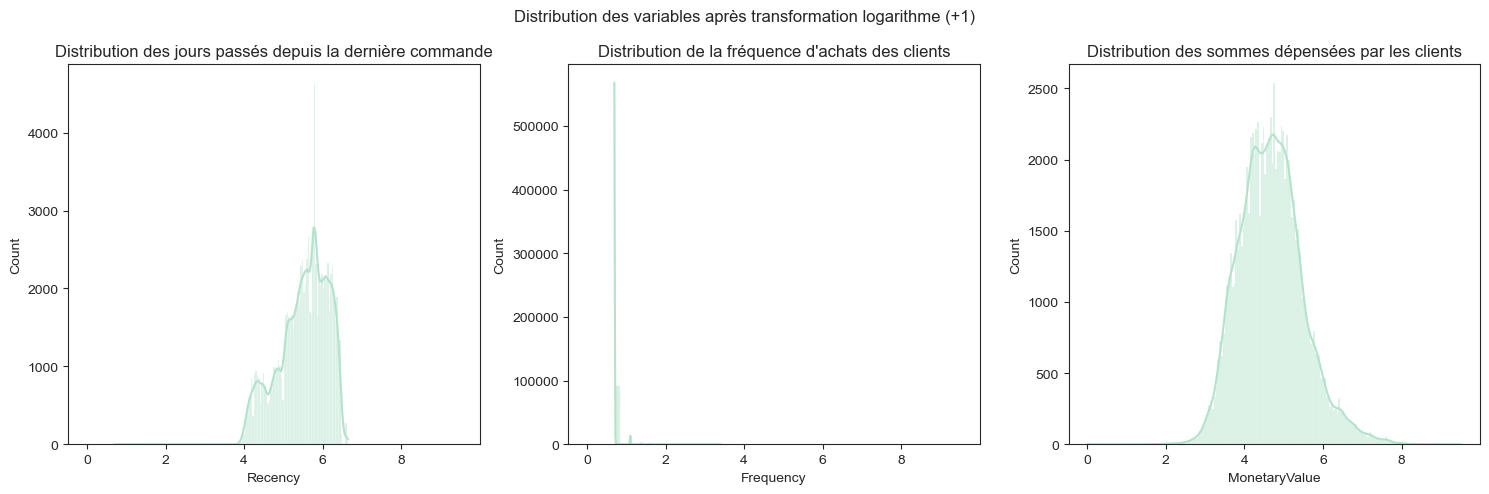

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
fig.suptitle('Distribution des variables après transformation logarithme (+1)')

sns.histplot(ax=axes[0], x="Recency", data=customers, kde=True)
axes[0].set_title("Distribution des jours passés depuis la dernière commande")

sns.histplot(ax=axes[1], x="Frequency", data=customers, kde=True)
axes[1].set_title("Distribution de la fréquence d'achats des clients")

sns.histplot(ax=axes[2], x="MonetaryValue", data=customers, kde=True)
axes[2].set_title("Distribution des sommes dépensées par les clients")

plt.tight_layout()
plt.show()

In [7]:
scaler = StandardScaler()

scaler.fit(customers)
customers_normalized = scaler.transform(customers)

print("Mean:", customers_normalized.mean(axis=0).round(2))
print("Standard Deviation:", customers_normalized.std(axis=0).round(2))

Mean: [-0. -0.  0.]
Standard Deviation: [1. 1. 1.]


La transformation logarithmique a permis de modifier la forme de la distribution des variables Recency et MonetaryValue pour qu'elle soit proche d'une distribution normale. Cette modification permet de rendre les modèles d'apprentissage non-supervisé comme l'algorithme K-Means d'être plus performant.

Une seconde étape a été de standardiser nos données. Ainsi, nos données ont toutes une moyenne de 0 avec un écart-type de 1. Là, encore cette modification a pour but d'améliorer la performance de nos modèles d'apprentissage non-supervisé. 

## Réduction de dimensions

La réduction de dimension a pour but de faciliter la visualisation de nos données en les ramenant dans un espace en 2 dimensions (même si dans ce cas, il aurait possible de les visualiser en 3 dimensions). De plus, la réduction de dimensions permet de diminuer le temps de calcul des algorithmes de clustering. 

In [8]:
n_comp = 2
pca = PCA(n_components=n_comp)
features = customers.columns
data_pca = pca.fit_transform(customers_normalized)
pcs = pca.components_

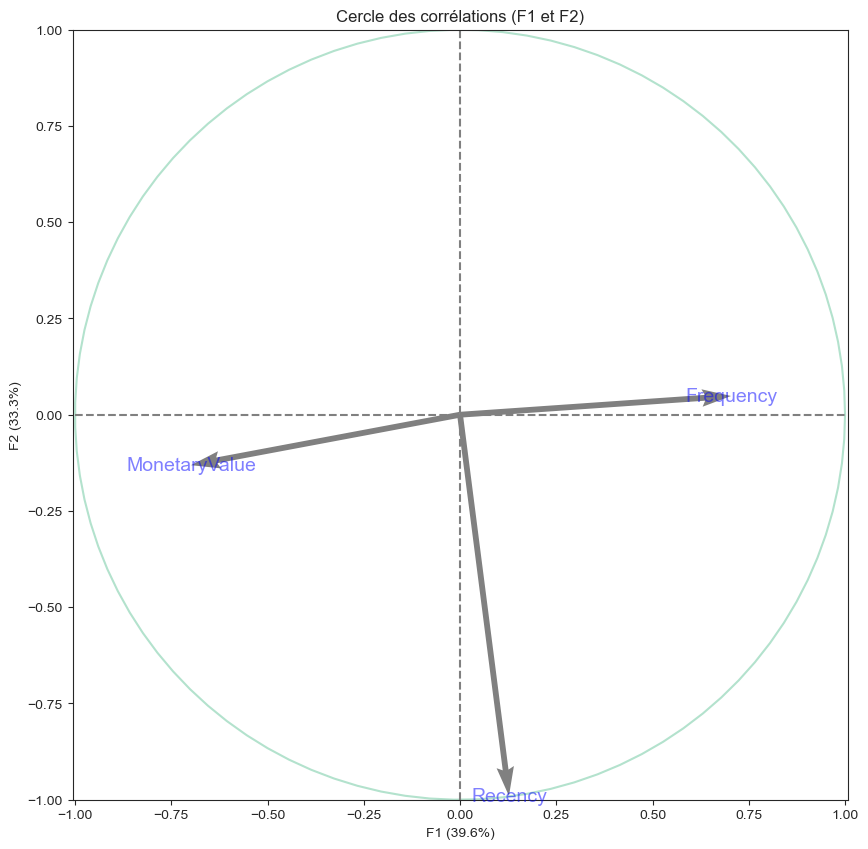

In [9]:
display_circles(pcs, n_comp, pca, [(0, 1)], labels=np.array(features))

# 2) Modélisation : K-Means

Une fois les étapes de pré-traitement réalisés, on va pouvoir passer à la modélisation. On va utiliser un algorithme K-Means qui se base sur des calculs de distance entre les points de notre jeu de données et un point nommé centroïde. Il est possible d'entrer les coordonnées de ce centroïde. Dans notre situation, on ne possède pas de contrainte sur le placement de ces centroïdes, on va donc laisser ce paramètre s'initialiser aléatoirement. En revanche, on va chercher à déterminer le nombre de clusters (le K du K-Means). Pour cela, on s'intéresse à l'évolution des distorsions avec la "méthode du coude" (**Elbow Method**). 

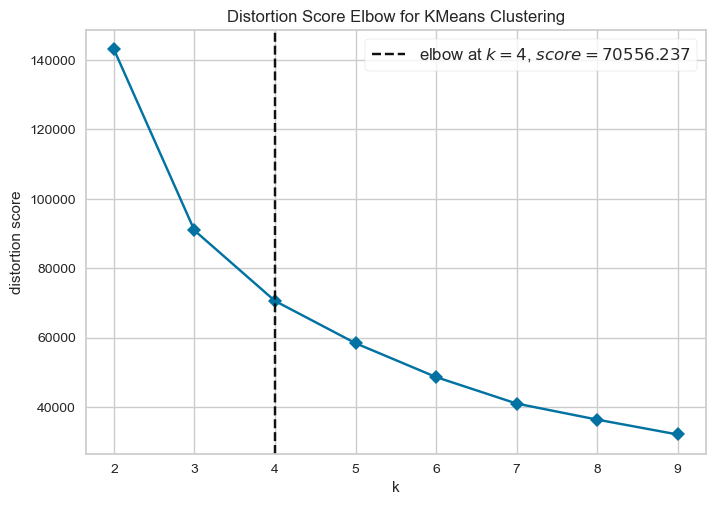

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [10]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10), timings=False)
visualizer.fit(data_pca)
visualizer.show()

Selon la méthode du coude, le nombre de cluster idéal est de **4**. On va donc entraîner notre modèle avec ce paramètre.

In [11]:
sns.set_palette("Pastel2")
sns.set_style("ticks")

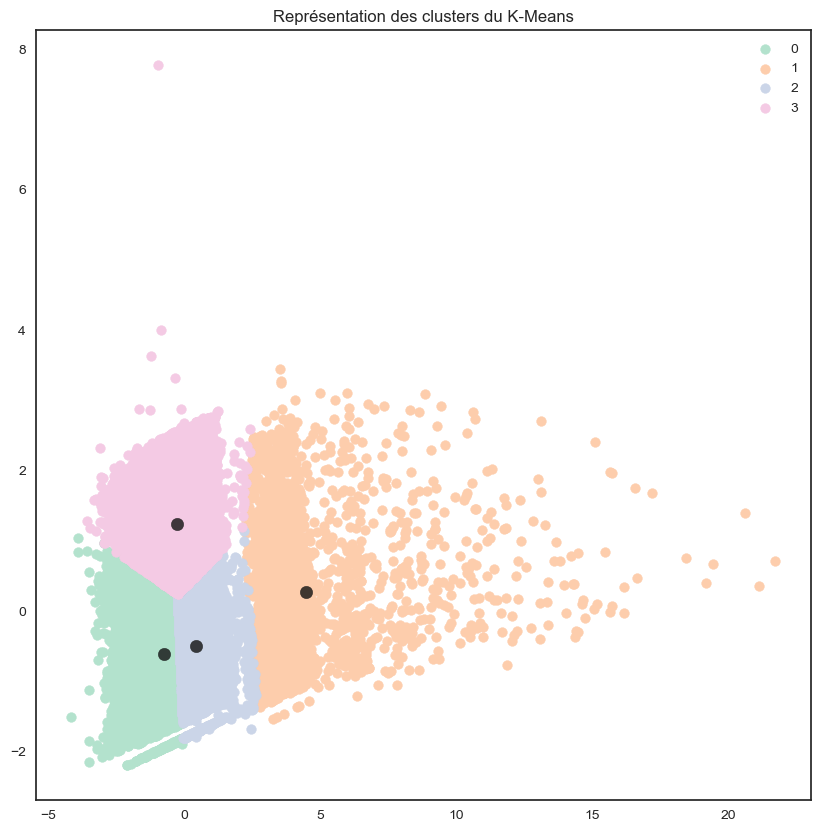

In [12]:
# Fitting KMeans
km = KMeans(n_clusters=4, random_state=42)

# Prediction
label = km.fit_predict(data_pca)
centroids = km.cluster_centers_
u_labels = np.unique(label)

# Graphical representation
plt.figure(figsize=(10, 10))
for i in u_labels:
    plt.scatter(data_pca[label==i, 0], data_pca[label==i, 1], label = i)
plt.scatter(centroids[:, 0], centroids[:,1], s=80, alpha=0.8, color='k')
plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.show()

## 2.1) Description des clusters obtenus avec le modèle

In [13]:
df["Cluster"] = km.labels_
df.groupby('Cluster').agg({
    'Recency' : "mean", 
    'Frequency' : "mean",
    'MonetaryValue': "mean"}).round(2)

,Recency,Frequency,MonetaryValue
Cluster,,,
0,353.02,1.00,302.41
1,311.59,2.54,50.86
2,370.03,1.00,69.50
3,120.61,1.00,139.61


In [14]:
df_normalized = pd.DataFrame(customers_normalized,
                             columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = df.index
df_normalized["Cluster"] = km.labels_

df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=["ID", "Cluster"],
                      value_vars=["Recency", "Frequency", "MonetaryValue"],
                      var_name="Attribute",
                      value_name="Value")

df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,0000366f3b9a7992bf8c76cfdf3221e2,3,Recency,-0.682494
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3,Recency,-0.652676
2,0000f46a3911fa3c0805444483337064,2,Recency,1.409650
3,0000f6ccb0745a6a4b88665a16c9f078,2,Recency,0.664037
4,0004aac84e0df4da2b147fca70cf8255,0,Recency,0.512653


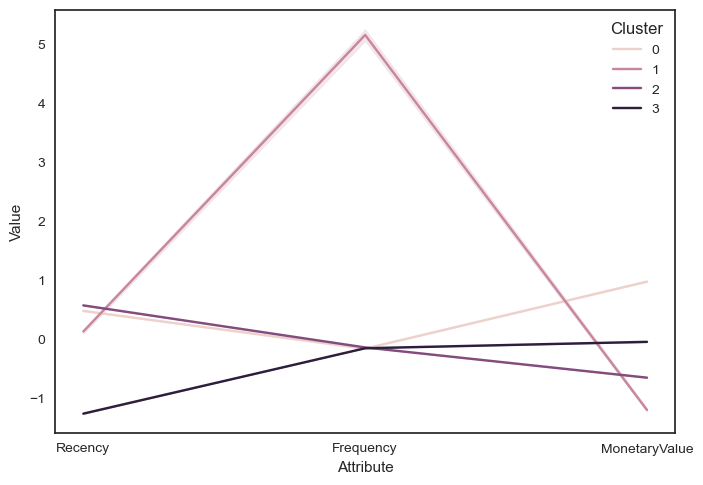

In [15]:
sns.lineplot("Attribute", "Value", hue="Cluster", data=df_nor_melt)
plt.show()

### Evaluation du modèle

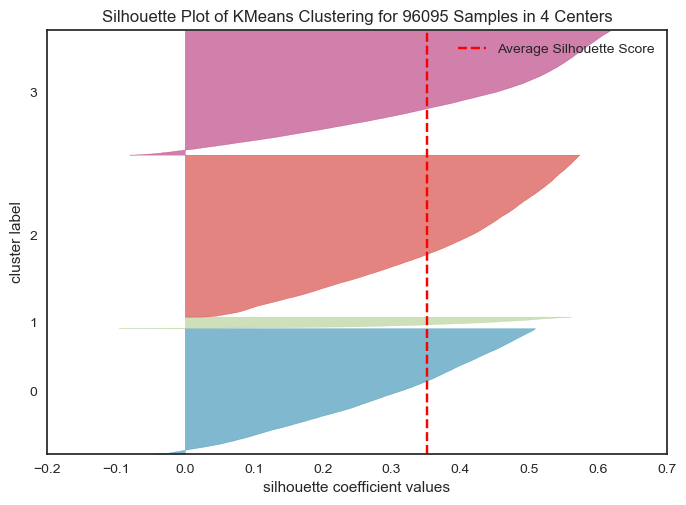

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 96095 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [16]:
visualizer = SilhouetteVisualizer(km, colors='yellowbrick')

visualizer.fit(data_pca)
visualizer.show()

In [17]:
print("Silhouette Score:", silhouette_score(data_pca, label))
print("Score de Davies-Bouldin:", davies_bouldin_score(data_pca, label))

Silhouette Score: 0.3522739358135876
Score de Davies-Bouldin: 0.8891491397647355


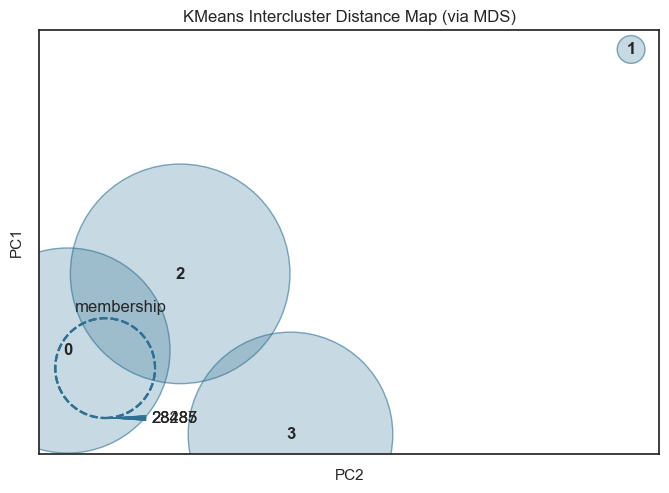

InterclusterDistance(ax=<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>,
                     estimator=KMeans(n_clusters=4, random_state=42))

In [18]:
from yellowbrick.cluster import intercluster_distance

intercluster_distance(KMeans(4, random_state=42), data_pca)

## 2.2) Conclusion

Trois de nos clusters semblent équilibrés et le dernier est plutôt faible. Ce cluster le plus petit est celui qui contient les clients ayant une fréquence d'achat supérieur à 2. Il s'agit donc des clients qui ont crée un compte et qui sont susceptibles de revenir régulièrement. Le reste des indices montre un clustering de bonne qualité. Cependant, la lecture des données ne permet de distinguer de véritables segmentations actionnables (outre les clients fidèles). On va donc essayer d'affiner cette segmentation en y ajoutant des variables supplémentaires. 

In [19]:
del data_pca
del df
del customers
del df_normalized
del df_nor_melt

In [20]:
gc.collect()

10

# 3) Segmentation sur 5 variables explicatives

In [21]:
data = pd.read_csv("datasets/data_clustering_complete.csv")
data.set_index("customer_unique_id", inplace=True)
data.head()

,customer_city,Recency,Frequency,MonetaryValue,r_quartile,f_bins,m_quartile,RFM_Score,distance_customer_seller,product_category_name,nb_days_before_delivered,review_score
customer_unique_id,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,cajamar,161,1,141.90,1,2,2,122,109.119060,bed_bath_table,6.0,5
0000b849f77a49e4a4ce2b2a4ca5be3f,osasco,164,1,27.19,1,2,4,124,22.813939,health_beauty,2.0,4
0000f46a3911fa3c0805444483337064,sao jose,586,1,86.22,4,2,3,423,516.989962,stationery,25.0,3
0000f6ccb0745a6a4b88665a16c9f078,belem,370,1,43.62,3,2,4,324,2479.718229,telephony,20.0,4
0004aac84e0df4da2b147fca70cf8255,sorocaba,337,1,196.89,3,2,1,321,153.807837,telephony,13.0,5


In [22]:
customers = pd.DataFrame()
customers["Recency"] = np.log1p(data['Recency'])
customers["Frequency"] = np.log1p(data["Frequency"])
customers["MonetaryValue"] = np.log1p(data["MonetaryValue"])
customers["nb_days_before_delivered"] = np.log1p(data["nb_days_before_delivered"])
customers["distance_customer_seller"] = np.log1p(data["distance_customer_seller"])
customers.tail()

,Recency,Frequency,MonetaryValue,nb_days_before_delivered,distance_customer_seller
customer_unique_id,,,,,
fffcf5a5ff07b0908bd4e2dbc735a684,6.208590,0.693147,7.634540,3.332205,7.599119
fffea47cd6d3cc0a88bd621562a9d061,5.743003,0.693147,4.449452,3.433987,7.329999
ffff371b4d645b6ecea244b27531430a,6.428105,0.693147,4.731450,2.708050,7.330095
ffff5962728ec6157033ef9805bacc48,5.135798,0.693147,4.902976,2.484907,6.459433
ffffd2657e2aad2907e67c3e9daecbeb,6.280396,0.693147,4.284414,1.945910,5.876906


In [23]:
scaler = StandardScaler()
customers_normalized = scaler.fit_transform(customers)

In [24]:
n_comp = 2
pca = PCA(n_components=n_comp)
customers_transform = pca.fit_transform(customers_normalized)
features = customers.columns
pcs = pca.components_

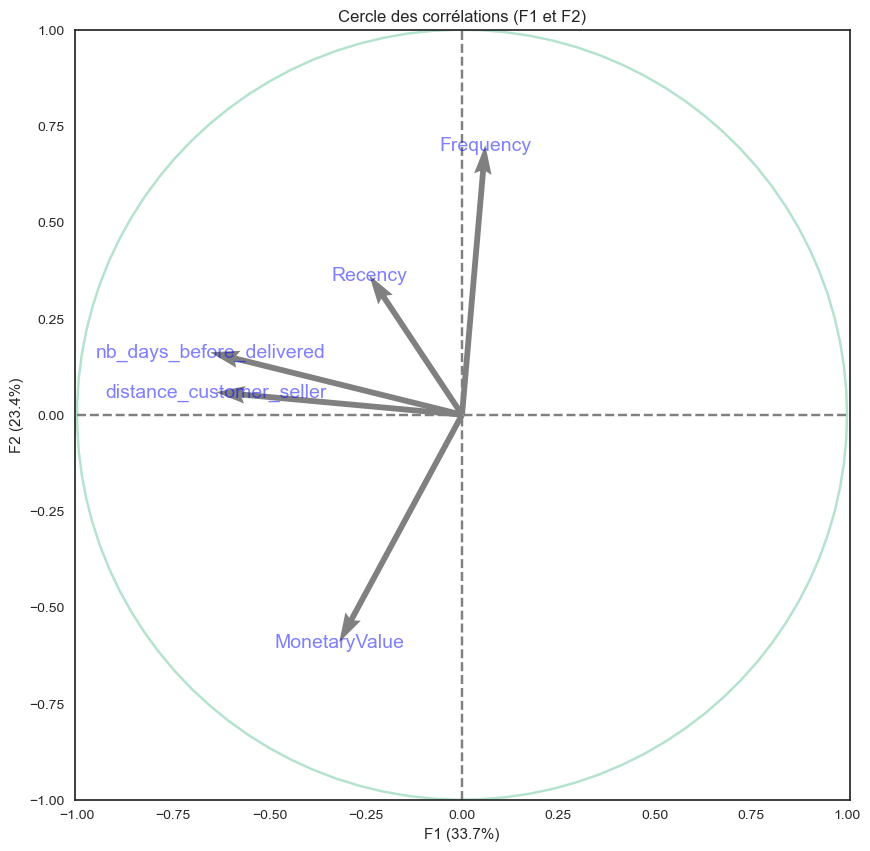

In [25]:
display_circles(pcs, n_comp, pca, [(0, 1)], labels=np.array(features))

## 3.2) Modélisation : K-Means

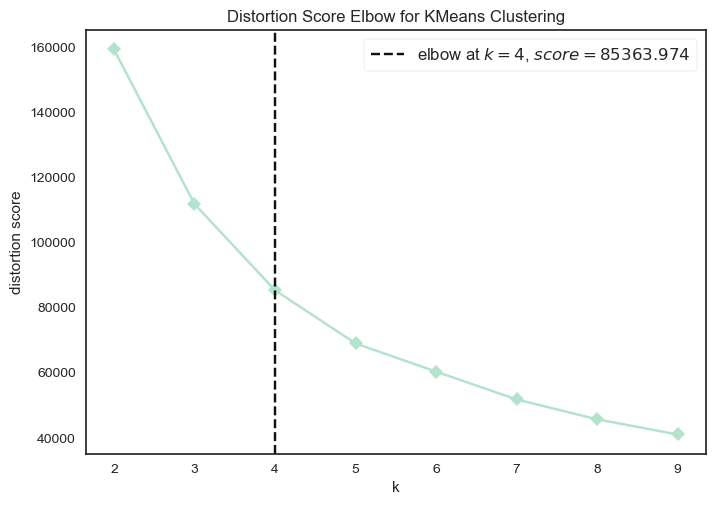

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [26]:
model = KMeans()
visualizer = KElbowVisualizer(model, k =(2,10), timings=False)
visualizer.fit(customers_transform)
visualizer.show()

In [27]:
sns.set_palette("Pastel2")
sns.set_style("ticks")

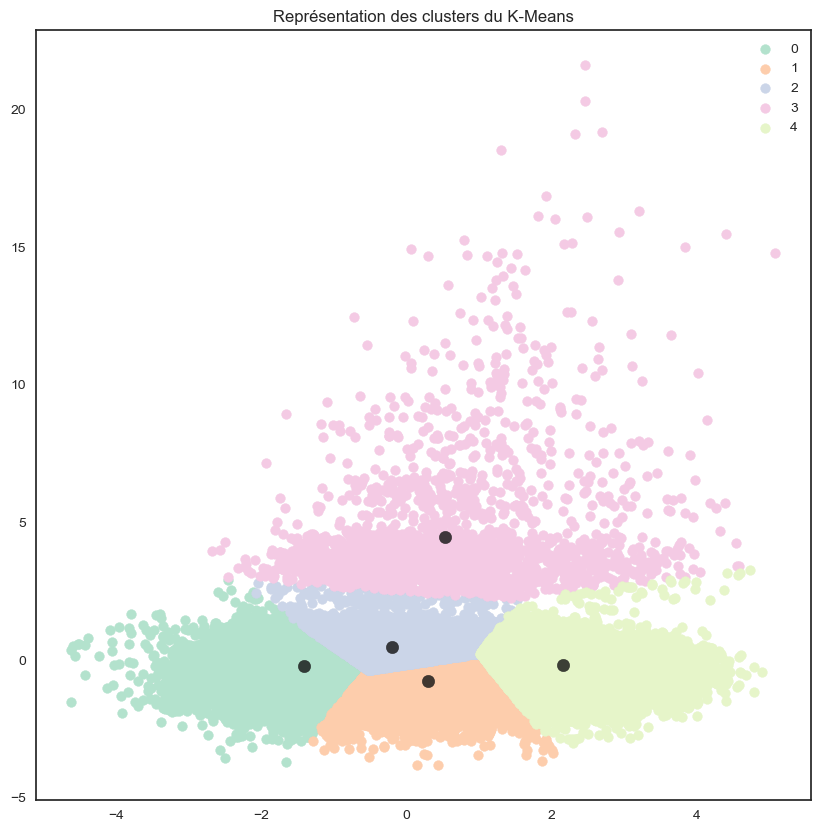

In [28]:
model = KMeans(n_clusters=5, random_state=42)

label = model.fit_predict(customers_transform)
centroids = model.cluster_centers_
u_labels = np.unique(label)

plt.figure(figsize=(10,10))
for i in u_labels:
    plt.scatter(customers_transform[label == i , 0] ,customers_transform[label == i , 1] , label=i)
plt.scatter(centroids[:,0], centroids[:,1] , s = 80, alpha=0.8, color='k')
plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.show()

In [29]:
data["Cluster"] = model.labels_
data_clusters_analysis = data.groupby('Cluster').agg({
    'Recency' : "mean", 
    'Frequency' : "mean",
    'MonetaryValue': "mean",
    'nb_days_before_delivered' : "mean",
    "distance_customer_seller" : "mean",
    "product_category_name" : lambda x : x.value_counts().index[0],
    "customer_city" : lambda x : x.value_counts().index[0],
    "review_score" : "mean"}).round(2)

In [30]:
df_normalized = pd.DataFrame(customers_normalized, columns=["Recency",
                                                            "Frequency",'MonetaryValue', 
                                                            "nb_days_before_delivered", "distance_customer_seller"])
df_normalized['ID'] = data.index
df_normalized["Cluster"] = model.labels_

df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=["ID", "Cluster"],
                      value_vars=["Recency", "Frequency", "MonetaryValue",
                                  "nb_days_before_delivered", "distance_customer_seller"],
                      var_name="Attribute",
                      value_name="Value")

df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,0000366f3b9a7992bf8c76cfdf3221e2,1,Recency,-0.678347
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4,Recency,-0.648391
2,0000f46a3911fa3c0805444483337064,0,Recency,1.423437
3,0000f6ccb0745a6a4b88665a16c9f078,0,Recency,0.674388
4,0004aac84e0df4da2b147fca70cf8255,1,Recency,0.522307


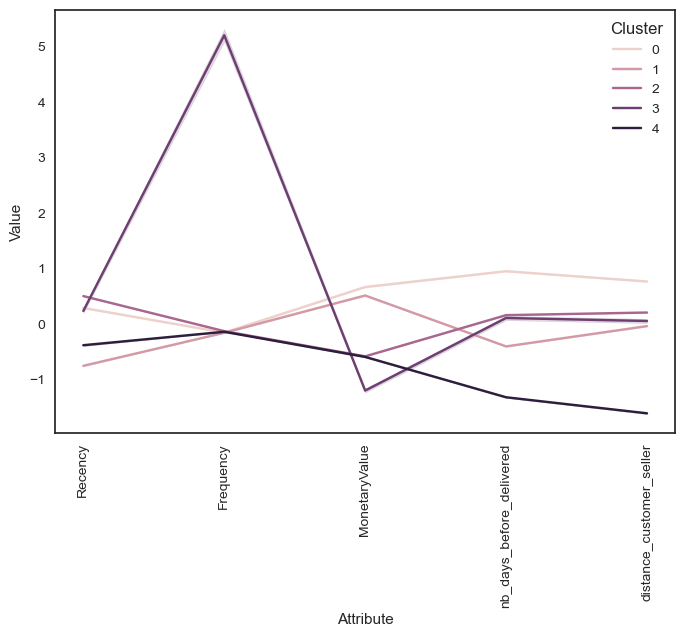

In [31]:
sns.lineplot("Attribute", "Value", hue="Cluster", data=df_nor_melt)
plt.xticks(rotation=90)
plt.show()

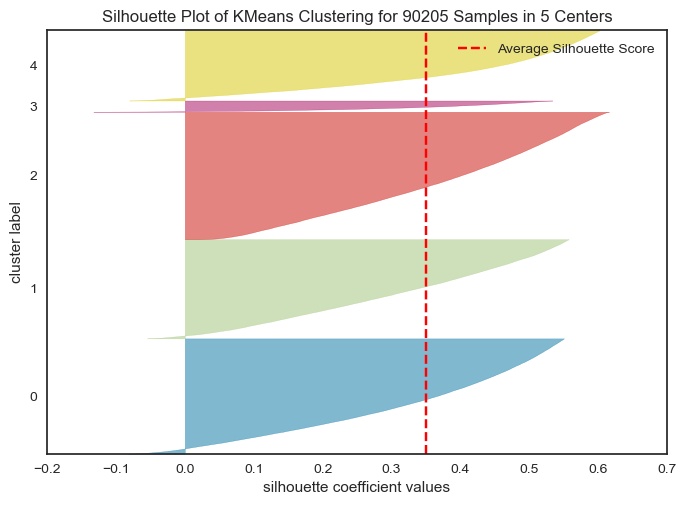

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 90205 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [32]:
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(customers_transform)
visualizer.show()

In [33]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

print("Silhouette Score:", \
      silhouette_score(customers_transform,\
                       label))
print("Score de Davies-Bouldin:", \
      davies_bouldin_score(customers_transform,\
                           label))

Silhouette Score: 0.3495988042935864
Score de Davies-Bouldin: 0.845429815060476


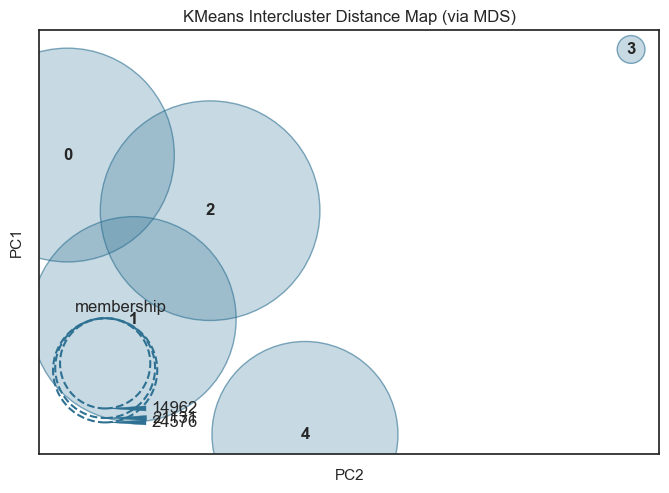

InterclusterDistance(ax=<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>,
                     estimator=KMeans(n_clusters=5, random_state=42))

In [34]:
intercluster_distance(KMeans(5, random_state=42), customers_transform)

## 3.2) Stabilité du clustering

On s'intéresse à la stabilité de notre algorithme pour déterminer les dates de maintenance de ce dernier. 

In [35]:
data_stability = pd.DataFrame()
data_stability["Recency"] = np.log1p(data["Recency"])
data_stability["Frequency"] = np.log1p(data["Frequency"])
data_stability["MonetaryValue"] = np.log1p(data["MonetaryValue"])
data_stability["nb_days_before_delivered"] = np.log1p(data["nb_days_before_delivered"])
data_stability["distance_customer_seller"] = np.log1p(data["distance_customer_seller"])

In [36]:
data_test_180d = data_stability.loc[data["Recency"] < 180]

In [37]:
customers_stability = customers.drop(index=data_test_180d.index)
customers_stability["Recency"] = customers_stability["Recency"].values \
                               - np.log1p(180)

In [38]:
customers_stability.head()

,Recency,Frequency,MonetaryValue,nb_days_before_delivered,distance_customer_seller
customer_unique_id,,,,,
0000f46a3911fa3c0805444483337064,1.176528,0.693147,4.468434,3.258097,6.249956
0000f6ccb0745a6a4b88665a16c9f078,0.717705,0.693147,3.798182,3.044522,7.816303
0004aac84e0df4da2b147fca70cf8255,0.624549,0.693147,5.287711,2.639057,5.042185
0004bd2a26a76fe21f786e4fbd80607f,0.079618,0.693147,5.123845,0.693147,3.363315
00050ab1314c0e55a6ca13cf7181fecf,0.005510,0.693147,3.594019,1.098612,4.635676


In [39]:
customers_test_stab = scaler.transform(customers_stability)
customers_test_stab = pca.transform(customers_test_stab)
label1 = model.predict(customers_test_stab)

In [40]:
stability = pd.DataFrame({"label_begin" : label1},
                         index=customers_stability.index)
stability.head(3)

,label_begin
customer_unique_id,
0000f46a3911fa3c0805444483337064,1
0000f6ccb0745a6a4b88665a16c9f078,1
0004aac84e0df4da2b147fca70cf8255,1


In [41]:
customers_stability["Recency"] = customers_stability["Recency"].values \
                                 + np.log1p(30)

In [42]:
customers_stability["Recency"] = customers_stability["Recency"].values \
                                + np.log1p(30)
customers_test_stab = scaler.transform(customers_stability)
customers_test_stab = pca.transform(customers_test_stab)
label2 = model.predict(customers_test_stab)
stability["label_30d"] = label2

In [43]:
customers_stability["Recency"] = customers_stability["Recency"].values \
                                + np.log1p(30)
customers_test_stab = scaler.transform(customers_stability)
customers_test_stab = pca.transform(customers_test_stab)
label3 = model.predict(customers_test_stab)
stability["label_60d"] = label3

In [44]:
customers_stability["Recency"] = customers_stability["Recency"].values \
                               + np.log1p(30)
customers_test_stab = scaler.transform(customers_stability)
customers_test_stab = pca.transform(customers_test_stab)
label4 = model.predict(customers_test_stab)
stability["label_90d"] = label4

In [45]:
customers_stability["Recency"] = customers_stability["Recency"].values \
                               + np.log1p(30)
customers_test_stab = scaler.transform(customers_stability)
customers_test_stab = pca.transform(customers_test_stab)
label5 = model.predict(customers_test_stab)
stability["label_120d"] = label5

In [46]:
customers_stability["Recency"] = customers_stability["Recency"].values \
                                + np.log1p(30)
customers_test_stab = scaler.transform(customers_stability)
customers_test_stab = pca.transform(customers_test_stab)
label6 = model.predict(customers_test_stab)
stability["label_150d"] = label6

In [47]:
customers_stability["Recency"] = customers_stability["Recency"].values \
                               + np.log1p(30)
customers_test_stab = scaler.transform(customers_stability)
customers_test_stab = pca.transform(customers_test_stab)
label7 = model.predict(customers_test_stab)
stability["label_180d"] = label7

In [48]:
stability.head(3)

,label_begin,label_30d,label_60d,label_90d,label_120d,label_150d,label_180d
customer_unique_id,,,,,,,
0000f46a3911fa3c0805444483337064,1,0,3,3,3,3,3
0000f6ccb0745a6a4b88665a16c9f078,1,0,3,3,3,3,3
0004aac84e0df4da2b147fca70cf8255,1,2,0,3,3,3,3


In [49]:
from sklearn.metrics import adjusted_rand_score

print("ARI à 1 mois :", \
      adjusted_rand_score(stability['label_begin'], \
                          stability["label_30d"]))
print("ARI à 2 mois :", \
      adjusted_rand_score(stability["label_begin"], \
                          stability["label_60d"]))
print("ARI à 3 mois :", \
      adjusted_rand_score(stability["label_begin"], \
                          stability["label_90d"]))
print("ARI à 4 mois :", \
      adjusted_rand_score(stability["label_begin"], \
                          stability["label_120d"]))
print("ARI à 5 mois :", \
      adjusted_rand_score(stability["label_begin"], \
                          stability["label_150d"]))
print("ARI à 6 mois :", \
      adjusted_rand_score(stability["label_begin"], \
                          stability["label_180d"]))

ARI à 1 mois : 0.2888050602107079
ARI à 2 mois : 0.1736500052994905
ARI à 3 mois : -0.01505885576741381
ARI à 4 mois : -0.00013259212187925328
ARI à 5 mois : 0.0
ARI à 6 mois : 0.0


La stabilité de notre modèle se dégrade très vite. Une maintenance mensuelle sera nécessaire pour pouvoir obtenir une segmentation qui ait encore du sens. 

In [50]:
stability.to_csv("datasets/stability.csv")
data_clusters_analysis.to_csv("datasets/clustering_analysis.csv")
data.to_csv("datasets/data_clusters.csv")

In [51]:
del stability
del data_clusters_analysis
del customers_stability

In [52]:
gc.collect()

13129

## 3.3) Conclusion

L'ajout de variable a permis d'obtenir une segmentation en 5 segments. On remarque que nos segments sont plutôt équilibrés mais qu'un segment contient moins de clients. Il s'agit des clients qui ont plusieurs commandes à leurs actifs. Il est aussi possible de distinguer des clients qui commandent à des vendeurs proches de leur lieu d'habitation ou encore des clients qui dépensent plus que les autres. 

Cependant, ce modèle ne semble pas stable et nécessitera une maintenance régulière. Ce problème de maintenance pourrait être combler par l'utilisation d'un algorithme incorporant d'autres variables, comme des variables catégorielles, mais aussi en obtenant des informations plus stables pour la récence et la fréquence. 

# 4) Segmentation sur 8 variables

## 4.1) Préparation des données

In [54]:
data.drop(["r_quartile", "f_bins", \
           "m_quartile", "RFM_Score", "Cluster"],
           axis=1, inplace=True)

In [55]:
data.head()

,customer_city,Recency,Frequency,MonetaryValue,distance_customer_seller,product_category_name,nb_days_before_delivered,review_score
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,cajamar,161,1,141.90,109.119060,bed_bath_table,6.0,5
0000b849f77a49e4a4ce2b2a4ca5be3f,osasco,164,1,27.19,22.813939,health_beauty,2.0,4
0000f46a3911fa3c0805444483337064,sao jose,586,1,86.22,516.989962,stationery,25.0,3
0000f6ccb0745a6a4b88665a16c9f078,belem,370,1,43.62,2479.718229,telephony,20.0,4
0004aac84e0df4da2b147fca70cf8255,sorocaba,337,1,196.89,153.807837,telephony,13.0,5


In [56]:
cols = data.columns

for col in cols:
    if data[col].dtypes == "float":
        data[col] = np.log1p(data[col].values)

In [57]:
cat_var = ["review_score", "customer_city", "product_category_name"]
num_var = ["Frequency", "Recency", "nb_days_before_delivered",
           "MonetaryValue", "distance_customer_seller"]

In [58]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing'))
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="median", fill_value="missing")),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
    ('cat', cat_pipe, cat_var),
    ('num', num_pipe, num_var)
])

In [59]:
data_normalized = preprocessor.fit_transform(data)
data_normalized = pd.DataFrame(data_normalized, columns=["review_score",
                                                         "customer_city",
                                                         "product_category_name",
                                                         "Frequency",
                                                         "Recency",
                                                         "nb_days_before_delivered",
                                                         "MonetaryValue",
                                                         "distance_customer_seller"])

In [60]:
for col in num_var:
    data_normalized[col] = data_normalized[col].astype("float32")

In [61]:
catColumnsPos = [data_normalized.columns.get_loc(col)\
                 for col in list(data_normalized.select_dtypes('object').columns)]
print('Categorical columns           : {}'.format(list(data_normalized.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['review_score', 'customer_city', 'product_category_name']
Categorical columns position  : [0, 1, 2]


In [62]:
dfMatrix = data_normalized.to_numpy()

## 4.2) Modélisation : K-Prototype

L'algorithme K-Prototype est un algorithme de la même famille que le K-Means. Cependant, le K-Prototype permet d'ajouter des variables catégorielles dans notre segmentation. On ajoute en plus des variables présentées dans le modèle précédents, la ville d'origine du client, l'avis moyen donné lors de ces commandes et le type de produits commandé. 

On choisit de diviser notre échantillon en 5 clusters.

In [63]:
kprototype = KPrototypes(n_jobs=-1,
                         n_clusters=5,
                         init='Huang',
                         random_state=42)
kprototype.fit_predict(dfMatrix,
                       categorical=catColumnsPos)

array([4, 1, 0, ..., 0, 4, 0], dtype=uint16)

In [64]:
data['cluster_id'] = kprototype.labels_

## 4.3) Analyse du clustering

In [65]:
data["review_score"] = data["review_score"].astype("int32")

In [66]:
for col in cols:
    if data[col].dtypes == "float":
        data[col] = np.expm1(data[col].values)

In [67]:
data_kproto_analysis = data.groupby('cluster_id').agg({
    'Frequency' : "mean",
    'MonetaryValue': "mean",
    'distance_customer_seller' : "mean",
    'nb_days_before_delivered' : "mean",
    'product_category_name' : lambda x: x.value_counts().index[0],
    'customer_city' : lambda x: x.value_counts().index[0],
    'review_score':"mean"}).round(2)

In [68]:
data_kproto_analysis

,Frequency,MonetaryValue,distance_customer_seller,nb_days_before_delivered,product_category_name,customer_city,review_score
cluster_id,,,,,,,
0,1.00,115.99,674.59,11.54,bed_bath_table,sao paulo,4.22
1,1.01,112.69,53.75,4.24,health_beauty,sao paulo,4.35
2,1.00,346.18,923.10,18.20,watches_gifts,rio de janeiro,3.81
3,2.54,55.79,659.01,12.54,bed_bath_table,sao paulo,4.10
4,1.00,88.04,638.06,11.44,bed_bath_table,sao paulo,4.20


In [69]:
data_kproto_analysis.to_csv("datasets/data_kproto_analysis.csv")

In [70]:
del dfMatrix

## 4.4) Stabilité de l'algorithme

On va chercher à établir la stabilité de l'algorithme pour définir les moments où réaliser des maintenances de notre algorithme. 

In [71]:
data_stability = pd.DataFrame()
data_stability["Recency"] = np.log1p(data["Recency"])
data_stability["Frequency"] = np.log1p(data["Frequency"])
data_stability["MonetaryValue"] = np.log1p(data["MonetaryValue"])
data_stability["nb_days_before_delivered"] = np.log1p(data["nb_days_before_delivered"])
data_stability["distance_customer_seller"] = np.log1p(data["distance_customer_seller"])
data_stability["product_category_name"] = data["product_category_name"]
data_stability["customer_city"] = data["customer_city"]
data_stability["review_score"] = data["review_score"]

In [72]:
data_test_180d = data.loc[data["Recency"] < 180]

In [73]:
data_stability = data_stability.drop(index=data_test_180d.index)
data_stability["Recency"] = data_stability["Recency"].values - np.log1p(180)

In [74]:
data_stability = data_stability[['customer_city',
                                 'Recency',
                                 'Frequency',
                                 'MonetaryValue',
                                 'distance_customer_seller',
                                 'product_category_name',
                                 'nb_days_before_delivered',
                                 'review_score']]

In [75]:
customers_test_stab = preprocessor.transform(data_stability)
customers_test_stab = pd.DataFrame(customers_test_stab, columns=["review_score",
                                                                 "customer_city",
                                                                 "product_category_name",
                                                                 "Frequency",
                                                                 "Recency",
                                                                 "nb_days_before_delivered", 
                                                                 "MonetaryValue",
                                                                 "distance_customer_seller"])
for col in num_var:
    customers_test_stab[col] = customers_test_stab[col].astype("float32")
catColumnsPos = [customers_test_stab.columns.get_loc(col) for col in list(customers_test_stab.select_dtypes('object').columns)]
dfMatrix = customers_test_stab.to_numpy()
label1 = kprototype.predict(dfMatrix, categorical=catColumnsPos)

In [76]:
stability = pd.DataFrame({"label_begin" : label1},
                         index=data_stability.index)
stability.head(3)

,label_begin
customer_unique_id,
0000f46a3911fa3c0805444483337064,4
0000f6ccb0745a6a4b88665a16c9f078,4
0004aac84e0df4da2b147fca70cf8255,4


In [77]:
data_stability["Recency"] = data_stability["Recency"].values + np.log1p(30)
customers_test_stab = preprocessor.transform(data_stability)
customers_test_stab = pd.DataFrame(customers_test_stab, columns=["review_score",
                                                                 "customer_city",
                                                                 "product_category_name",
                                                                 "Frequency",
                                                                 "Recency",
                                                                 "nb_days_before_delivered",
                                                                 "MonetaryValue",
                                                                 "distance_customer_seller"])
for col in num_var:
    customers_test_stab[col] = customers_test_stab[col].astype("float32")
catColumnsPos = [customers_test_stab.columns.get_loc(col) for col in list(customers_test_stab.select_dtypes('object').columns)]
dfMatrix = customers_test_stab.to_numpy()
stability["label_30d"] = kprototype.predict(dfMatrix, categorical=catColumnsPos)

In [78]:
data_stability["Recency"] = data_stability["Recency"].values \
                          + np.log1p(30)
customers_test_stab = preprocessor.transform(data_stability)
customers_test_stab = pd.DataFrame(customers_test_stab, columns=["review_score",
                                                                 "customer_city",
                                                                 "product_category_name",
                                                                 "Frequency",
                                                                 "Recency",
                                                                 "nb_days_before_delivered",
                                                                 "MonetaryValue",
                                                                 "distance_customer_seller"])
for col in num_var:
    customers_test_stab[col] = customers_test_stab[col].astype("float32")
catColumnsPos = [customers_test_stab.columns.get_loc(col) for col in list(customers_test_stab.select_dtypes('object').columns)]
dfMatrix = customers_test_stab.to_numpy()
stability["label_60d"] = kprototype.predict(dfMatrix, categorical = catColumnsPos)

In [79]:
data_stability["Recency"] = data_stability["Recency"].values \
                            + np.log1p(30)
customers_test_stab = preprocessor.transform(data_stability)
customers_test_stab = pd.DataFrame(customers_test_stab, columns=["review_score", "customer_city", "product_category_name",
                                                         "Frequency", "Recency", "nb_days_before_delivered", 
                                                         "MonetaryValue", "distance_customer_seller"])
for col in num_var:
    customers_test_stab[col] = customers_test_stab[col].astype("float32")
catColumnsPos = [customers_test_stab.columns.get_loc(col)\
                 for col in list(customers_test_stab.select_dtypes('object').columns)]
dfMatrix = customers_test_stab.to_numpy()
stability["label_90d"] = kprototype.predict(dfMatrix,
                                            categorical = catColumnsPos)

In [80]:
data_stability["Recency"] = data_stability["Recency"].values \
                            + np.log1p(30)
customers_test_stab = preprocessor.transform(data_stability)
customers_test_stab = pd.DataFrame(customers_test_stab, columns = ["review_score",
                                                                   "customer_city",
                                                                   "product_category_name",
                                                                   "Frequency",
                                                                   "Recency",
                                                                   "nb_days_before_delivered",
                                                                   "MonetaryValue",
                                                                   "distance_customer_seller"])
for col in num_var:
    customers_test_stab[col] = customers_test_stab[col].astype("float32")
catColumnsPos = [customers_test_stab.columns.get_loc(col) \
                 for col in list(customers_test_stab.select_dtypes('object').columns)]
dfMatrix = customers_test_stab.to_numpy()
stability["label_120d"] = kprototype.predict(dfMatrix,
                                             categorical = catColumnsPos)

In [81]:
data_stability["Recency"] = data_stability["Recency"].values \
                            + np.log1p(30)
customers_test_stab = preprocessor.transform(data_stability)
customers_test_stab = pd.DataFrame(customers_test_stab, columns=["review_score",
                                                                 "customer_city",
                                                                 "product_category_name",
                                                                 "Frequency",
                                                                 "Recency",
                                                                 "nb_days_before_delivered",
                                                                 "MonetaryValue",
                                                                 "distance_customer_seller"])
for col in num_var:
    customers_test_stab[col] = customers_test_stab[col].astype("float32")
catColumnsPos = [customers_test_stab.columns.get_loc(col)\
                 for col in list(customers_test_stab.select_dtypes('object').columns)]
dfMatrix = customers_test_stab.to_numpy()
stability["label_150d"] = kprototype.predict(dfMatrix,\
                                             categorical = catColumnsPos)

In [82]:
data_stability["Recency"] = data_stability["Recency"].values \
                          + np.log1p(30)
customers_test_stab = preprocessor.transform(data_stability)
customers_test_stab = pd.DataFrame(customers_test_stab, columns=["review_score",
                                                                 "customer_city",
                                                                 "product_category_name",
                                                                 "Frequency",
                                                                 "Recency",
                                                                 "nb_days_before_delivered",
                                                                 "MonetaryValue",
                                                                 "distance_customer_seller"])
for col in num_var:
    customers_test_stab[col] = customers_test_stab[col].astype("float32")
catColumnsPos = [customers_test_stab.columns.get_loc(col)\
                 for col in list(customers_test_stab.select_dtypes('object').columns)]
dfMatrix = customers_test_stab.to_numpy()
stability["label_180d"] = kprototype.predict(dfMatrix,
                                             categorical = catColumnsPos)

In [83]:
from sklearn.metrics import adjusted_rand_score

print("ARI à 1 mois :",\
      adjusted_rand_score(stability['label_begin'],\
                          stability["label_30d"]))
print("ARI à 2 mois :",\
      adjusted_rand_score(stability["label_begin"],\
                          stability["label_60d"]))
print("ARI à 3 mois :",\
      adjusted_rand_score(stability["label_begin"],\
                          stability["label_90d"]))
print("ARI à 4 mois :",\
      adjusted_rand_score(stability["label_begin"],\
                          stability["label_120d"]))
print("ARI à 5 mois :",\
      adjusted_rand_score(stability["label_begin"],\
                          stability["label_150d"]))
print("ARI à 6 mois :",\
      adjusted_rand_score(stability["label_begin"],\
                          stability["label_180d"]))

ARI à 1 mois : 0.993954277248149
ARI à 2 mois : 0.9884278987142789
ARI à 3 mois : 0.982366709199947
ARI à 4 mois : 0.975723958997046
ARI à 5 mois : 0.9705655463321475
ARI à 6 mois : 0.9646244392955026


Au bout de 6 mois, on remarque que notre segmentation évolue très peu. Il peut être envisagé de faire une maintenance de l'algorithme tous les ans si cette solution est adoptée. 

## 4.5) Conclusion

Le modèle K-Prototype permet d'obtenir des résultats similaires au K-Means et nécessite une maintenance moins importante. Cependant, pour rendre nos modélisations de meilleures qualités, il pourrait être intéressant d'obtenir des informations démographiques sur nos clients ainsi que de trouver un moyen de les suivre pour pouvoir utiliser les variables de récence et de fréquence d'achat qui sont pour le moment très peu discriminative. 

L'utilisation d'algorithme de Machine Learning permet d'obtenir des segments actionnables en prenant en compte plus de variable que les segmentations classiques, type RFM. On va aussi pouvoir obtenir moins de segments de clientèle (5 segments avec des algorithmes de clustering vs 32 segments avec la segmentation RFM). Il sera donc probablement plus aisé de faire des offres une fois les 5 segments définis que lorsqu'on a défini 32 segments. 

In [84]:
stability.to_csv("datasets/stability_kproto.csv")
data.to_csv("datasets/data_kprototype.csv")

**Références :**

https://towardsdatascience.com/the-k-prototype-as-clustering-algorithm-for-mixed-data-type-categorical-and-numerical-fe7c50538ebb